# Data Wrangling

# by Amer Jadid

## Table of Content:

- [1. Gathering Data](#1)
    - [1.1 Download 'twitter-archive-enhanced.csv' manually.](#1.1)
    - [1.2 Download 'image-predictions.tsv' programatically.](#1.2)
    - [1.3 Use Tweepy to query Twitter's API for additional data](#1.3)
- [2. Assessing Data](#2)
    - [2.1 Quality Issues](#2.1)
    - [2.2 Tidiness Issues](#2.2)
- [3. Cleaning Data](#3)
    - [3.1 Define](#3.1)
    - [3.2 Code & Test](#3.2)
     - [3.2.1 `twitt_arch` table](#3.2.1)
     - [3.2.2 `img_pred` table](#3.2.2)
     - [3.2.3 `tweets` table](#3.2.3)
- [4. Storing Data in SQLite Data Base](#4)
- [5. Analysis and Visualization](#5)
    - [5.1 Word Cloud](#5.1)
    - [5.2 Page Popularity](#5.2)
    - [5.3 Rating and Dog Stage Heatmap](#5.3)
    - [5.4 Proportion of Predictions that are Actual Dogs](#5.4)
    - [5.5 Data Query](#5.5)
     - [5.5.1 `Analyze Tweet Sentiment`](#5.5.1)
     - [5.5.2 `Conclusion`](#5.5.2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tweepy
import re
import missingno as msno
pd.options.display.max_columns = 100
sns.set_style()

from urllib.request import urlretrieve
import json
import requests
import os.path
from zipfile import ZipFile

%matplotlib inline

# 1. Gathering Data<a id='1'></a>
</br>

## Create a folder to store all data

In [2]:
#Create a data folder to store all data 
if os.path.exists('data'):
    print("Data folder already exists.")
else:
    os.makedirs('data')
    print("Data folder created")

Data folder already exists.


## 1.1 Download 'twitter-archive-enhanced.csv' manually.<a id='1.1'></a>

In [3]:
#Download file manually & save it into the data folder.
twitt_arch_path = 'data\\'+ 'twitter-archive-enhanced.csv'
#read 'twitter-archive-enhanced.csv' into a dataframe & create a copy
twitt_arch_raw = pd.read_csv(twitt_arch_path)
twitt_arch = twitt_arch_raw.copy(deep = True)

## 1.2 Download 'image-predictions.tsv' programatically.<a id='1.2'></a>

In [4]:
#use requests library to download image predictions file programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
img_pred_path = 'data\\'+ url.split('/')[-1]
if os.path.exists(img_pred_path):
    print("'image-predictions.tsv' already exists.")
else:
    response = requests.get(url)
    with open(os.getcwd() + '\\' + img_pred_path, 'wb') as file:
        file.write(response.content)
    print("image-predictions.tsv' is now in you local directory.")

'image-predictions.tsv' already exists.


In [5]:
#Read 'image-predictions.tsv' into a dataframe & create a copy
img_pred_raw = pd.read_csv(img_pred_path, sep='\t')
img_pred = img_pred_raw.copy(deep = True)

## 1.3 Use Tweepy to query Twitter's API for additional data<a id='1.3'></a>

In [ ]:
import tweepy

consumer_key = 'YOUR-CONSUMER-KEY'
consumer_secret = 'YOUR-CONSUMER-SECRET'
access_token = 'YOUR-ACCESS-TOKEN'
access_secret = 'YOUR-ACCESS-SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
#Get list for all id's from the img_pred and twitt_arch
tweets_id = list(set(img_pred.tweet_id).union(set(twitt_arch.tweet_id)))

In [ ]:
#Write JSON data to the required tweet_json.txt file with each tweet's JSON data on its own line
#Create a time list to record the time required for each id query
time_list = []
#Record the time for the overall process
over_all_start = time.time()
with open('tweet_json.txt', 'a') as outfile:
    for tweet_id in tweets_id:
        try:
            start = time.time()
            tweet = api.get_status(tweet_id, tweet_mode='extended')._json
            json.dump(tweet, outfile)
            outfile.write('\n')
            end = time.time()
            time_list.append(end - start)
        except:
            pass
over_all_end = time.time()
overall_time = over_all_end - over_all_start

In [ ]:
#save the time needed to query each tweet
np.savetxt('data/tweet_query_time.csv', time_list)
#save the time needed to query all tweets
np.savetxt('data/over_all_query_time.csv', np.array([overall_time]))

In [6]:
#Read the text file line by line and add it to a list
tweet_json_path = 'data/tweet_json.txt'
tweets_list = [json.loads(line) for line in open(tweet_json_path)]
#Create a pandas dataframe from the list of JSON tweets
tweets_raw = pd.DataFrame(tweets_list)
#create a copy of the tweets_raw dataframe
tweets = tweets_raw.copy(deep = True)

# 2. Assessing Data<a id='2'></a>
</br>

### 2.1 Quality Issues:<a id='2.1'></a>
#### `twitt_arch` table

   - `1. Visual Assessment` using spreadsheet:
      - Missing values in `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`
      - `doggo`, `floofer`, `pupper`, & `puppo` seems to have `None` values which is `missing values` 
      - `Name` column contains stopping words like the word `the` & `a`, and missing values like `None.`
      
      
   - `2. Programmatic assessment`:
       - More than 90% of data in columns [(Figure 1)](#Figure1) `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are missing, while about 2.5% of `expanded_urls` is missing.
       - `rating_denominator` & `rating_numerator` [(Table 1.1)](#Table1) has some values different than 10, where these values are extracted in a wrong way or written on purpose by the author.
       - `Inconsistency` in the naming of `dog stages` inside the `tweet text`[(Table 1.2)](#Table1), which led to `improper extraction of dog stages name`, for example: puppo dog stage is written as `puppologize instead of puppo tweet id: 866686824827068416.`
       - Duplicates in the `expanded_urls`, where tweets include mentions of author for another tweets with the same text [(Table 2)](#Table2).
</br>

#### `img_pred` table
   
   - `p1`, `p2`, & `p3` have first letter naming inconsistency (upper and lower case).
   - `duplicates` in the `jpg_url` column
</br>
   
#### `tweets` table
   - `Visual Assessment` using spreadsheet:
    - Multiple columns have missing values.
    - Some columns present no meaningful data such as `truncated` and `display_text_range` column.
</br>

   - `Programmatic` assessment
    - Multiple columns have more than 90% missing values [(Table 3)](#Table3).

### 2.2 Tidiness Issues:<a id='2.2'></a>
#### `twitt_arch` table

   - Redundant columns `doggo`, `floofer`, `pupper`, & `puppo`
   - some 'extended_urls' contains multiple urls.
   - `text column` contains 2 variables, `tweet text` and the `tweet url`, where the `tweet url` in the text column represents the `same as` the `extended_urls` columns.

#### `img_pred` table
   - Column redundancy in `p1, p2, p3, p1_dog, p2_dog, p3_dog, p1_conf, p2_conf, and p3_conf.`
</br>
   
#### `tweets` table

   - Some columns are redundant with different data type such as `id and id_str`.
   - `entities`, `extended_entities` and `user` columns have multiple values or dictionaries.
   -------

<a class="anchor" id="Figure1"></a>
#### Figure 1. Percentage of missing data in each column in the twitt_arch dataframe

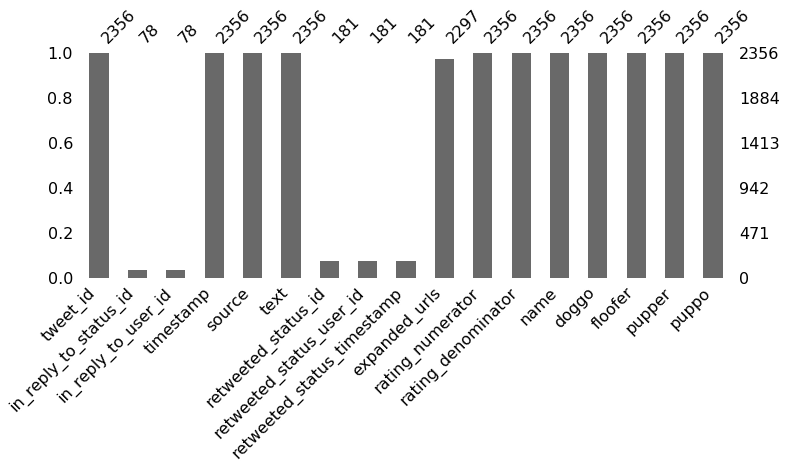

In [7]:
#use missingno module to analyse the missing data
msno.bar(twitt_arch, figsize = [11.69, 8.27/2]);

<a class="anchor" id="Table1"></a>
#### Table 1. text, rating_numerator, and rating_denominator

In [8]:
#change the max_colwidth to view all the tweet inside the text column
pd.options.display.max_colwidth = 200
display(twitt_arch[twitt_arch.rating_denominator != 10][['text', 'rating_numerator', 'rating_denominator']].head(10))
#reset the max_colwidth
print('--------------------Table 1.1--------------------')
display(twitt_arch[twitt_arch.tweet_id == 866686824827068416][['text', 'puppo']])
print('--------------------Table 1.2--------------------')
pd.options.display.max_colwidth = 50

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


--------------------Table 1.1--------------------


,text,puppo
134,This is Lili. She can't believe you betrayed her with bath time. Never looking you in the eye again. 12/10 would puppologize profusely https://t.co/9b9J46E86Z,None


--------------------Table 1.2--------------------


<a class="anchor" id="Table2"></a>
#### Table 2. tweet text duplicates

In [9]:
pd.options.display.max_colwidth = 200
display(twitt_arch[twitt_arch.tweet_id.isin([831650051525054464, 852936405516943360])][['text', 'rating_numerator', 'rating_denominator']])
pd.options.display.max_colwidth = 50

,text,rating_numerator,rating_denominator
204,"RT @dog_rates: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t…",13,10
349,"I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https://t.co/1UHrKcaCiO",13,10


In [10]:
mask = twitt_arch[twitt_arch.expanded_urls.duplicated(False)].sort_values('expanded_urls').expanded_urls.str[:len('https://twitter.com')] != 'https://twitter.com'
mask_index = twitt_arch[twitt_arch.expanded_urls.duplicated(False)].sort_values('expanded_urls').expanded_urls.str[:len('https://twitter.com')][mask].index
#twitt_arch.iloc[mask_index]

<a class="anchor" id="Table3"></a>
#### Table 3. tweets data missingness

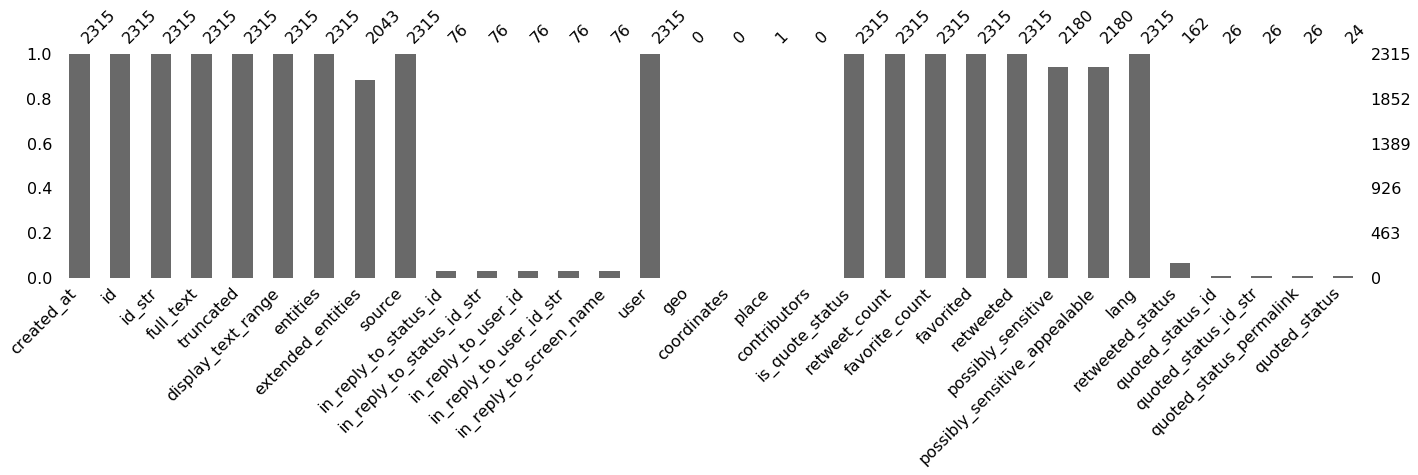

In [11]:
#use missingno module to analyse the missing data
msno.bar(tweets, figsize = [11.69*2, 8.27/2]);

In [12]:
tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Mon Nov 16 00:35:11 +0000 2015,666051853826850816,666051853826850816,This is an odd dog. Hard on the outside but lo...,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666051848592334848, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,778,1129,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Mon Nov 16 00:24:50 +0000 2015,666049248165822465,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,39,96,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Nov 16 03:22:39 +0000 2015,666094000022159362,666094000022159362,This appears to be a Mongolian Presbyterian mi...,False,"[0, 132]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666093996847063040, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,67,154,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Mon Nov 16 21:54:18 +0000 2015,666373753744588802,666373753744588802,Those are sunglasses and a jean jacket. 11/10 ...,False,"[0, 81]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666373746337402880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,84,174,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Mon Nov 16 00:49:46 +0000 2015,666055525042405380,666055525042405380,Here is a Siberian heavily armored polar bear ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666055517517848576, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,221,410,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


--------------

# 3. Cleaning Data<a id='3'></a>

### 3.1 Define:<a id='3.1'></a>

`twitt_arch` table

   - `Drop all columns` that contains more than `50% missing values. `
   - Replace `None` with `np.nan` for `doggo, floofer, pupper, and puppo `columns.
   - For the `Name` column Remove stopping words using `NLTK` package.
   - `re-extract` the incorrect `rating_denominator` and `rating_numerator` from the `text` column, using regular expressions.
   - re-extract dog stages using fuzzywuzzy package, since some dog stages have inconsistent naming inside the text column.
   - remove duplicates by the expanded_urls.
   - `tiding` columns `doggo, floofer, pupper, & puppo` using  `melt` function from pandas.
   - for the `extended_urls`, extract only one url containing `https://twitter.com` with regular expression module.
   - discard the url from the text column of 'https:'
   
`img_pred` table

   - Make first letter for p1, p2, and p3 lower case
   - tidy `p`, `p_dog`, and `p_conf` columns using melt function.
   - Remove duplicates using `.drop_duplicates()` method

`tweets` table

   - `dropping all columns` that contains more than `50% missing values.`
   - remove redundant columns.
   - use json_normalize method to normalize columns containing dictionaries.

### 3.2 Code & Test:<a id='3.2'></a>

#### 3.2.1 `twitt_arch` table:<a id='3.2.1'></a>

##### 1 - `Drop all columns` that contains more than `50% missing values.`

In [13]:
#`Drop all columns` that contains more than `50% missing values.`
thresh = int(len(twitt_arch)/2)
twitt_arch.dropna(thresh = thresh, axis = 1, inplace = True)

##### 2 - Replace `None` with `np.nan` for `doggo, floofer, pupper, and puppo `columns.

In [14]:
#Replace `None` with `np.nan` for `doggo, floofer, pupper, and puppo `columns.
twitt_arch.replace('None', np.nan, inplace = True)

##### 3 - Remove Stopping words from the `name` column

In [15]:
#For the `Name` column Remove stopping words using `NLTK` package.
#Import NLTK package to remove stopping words
import nltk
from nltk.corpus import stopwords 
#download english stopping words
#nltk.download('stopwords')
#nltk.download('punkt')

#Create a set af all english stopping word
stop_words = set(stopwords.words('english'))
#Remove stopping words
twitt_arch.loc[twitt_arch.name.isin(stop_words), 'name'] = np.nan

##### 4 - Remove duplicates by the expanded_urls column

In [16]:
#Remove duplicates by the expanded_urls column
twitt_arch.drop_duplicates(['expanded_urls'], inplace = True)

##### 5 - Split and discard the url from the text column of 'https:'

In [17]:
#split and discard the url from the text column of 'https:'
twitt_arch.text = twitt_arch.text.str.split('https:', expand = True)[0]

##### 6 - Re-extracting dog stage from the text column

In [18]:
#re-extracting dog stage from the text column using fuzzywuzzy package
from fuzzywuzzy import process
from nltk.tokenize import word_tokenize

stages = ['doggo', 'floofer', 'pupper', 'puppo']

#create a function to remove english stopwords 
def remove_stopwords(word_tokens, stop_words = stop_words):
    return [w for w in word_tokens if w not in stop_words.union(set(['this', '.', 'he', "'s"]))]

#remove stopwords and create a list of words from the text column
twitt_arch['text_no_stop_words'] = twitt_arch['text'].str.lower().apply(word_tokenize).apply(remove_stopwords)

#Create function to extract the closest word from the newly created list to our dog stage
def dog_stage(text_list, stage = 'doggo'):
    stage_list = list(max(process.extract(stage, text_list), key = lambda x: x[1]))
    return stage_list + [stage]

#Create a list of all words that are close to our dog stages
conf_stage = []
for stage in stages:
    conf_stage.append(list(twitt_arch.text_no_stop_words.apply(dog_stage, stage = stage)))

#join all closest words in 1 column    
type_conf_stage = pd.Series([list(x) for x in zip(*conf_stage)]).apply(max, key = lambda x: x[1])

#create 3 columns, where the first is the dog stage extracted from the text column
#second is the percentage similarity with the dog stage
#third is the actual dog stage
for i, col_name in enumerate(['dog_stage_from_text', 'dog_stage_conf', 'dog_stage']):
    twitt_arch[col_name] = type_conf_stage.apply(lambda x: x[i])
    
#leave only dog stages (extracted from text) that are 50% of more similar to our 4 main dog stages
mask = twitt_arch.dog_stage_conf < 50
twitt_arch.loc[mask, ['dog_stage_from_text', 'dog_stage_conf', 'dog_stage']] = np.nan
twitt_arch.drop(['doggo', 'floofer', 'pupper', 'puppo', 'text_no_stop_words', 'dog_stage_from_text'], axis = 1, inplace = True)

##### 7 - Keep one url in the expanded_urls and fill missing values with with correct url

In [19]:
#Use regular expression to clean the expanded_urls column where we choose only the url starting with 'https://twitter.com'
expanded_urls = twitt_arch.expanded_urls.str.findall(r'https://twitter.com/dog_rates/status/\d+/photo/1')
#replace empty list with np.nan
empty_list = (expanded_urls.astype(str) == '[]')[expanded_urls.astype(str) == '[]'].index
expanded_urls[empty_list] = np.nan
#select the first matching string 
twitt_arch.expanded_urls = expanded_urls[expanded_urls.notna()].apply(lambda x: x[0])
#replace np.nan with the the link extracted from the tweet_id
twitt_arch.loc[twitt_arch.expanded_urls.isna(), 'expanded_urls'] = 'https://twitter.com/dog_rates/status/' + str(twitt_arch.tweet_id) + '/photo/1'

##### 8 - Re-extract the rating from the text column 

In [20]:
#find all ratings in each tweet text using regular expressions
rating_lists_raw = twitt_arch.text.str.findall(r'\d+/\d+')
rating_lists = rating_lists_raw.copy(deep = True)
print('Rating Expression')
display(rating_lists.head())
print('---------------------')
#calculate the number of ratings found in each text 
rating_list_len = rating_lists.apply(lambda x: len(x))
print('Count of Ratings Per Tweet')
display(rating_list_len.value_counts())

Rating Expression


0    [13/10]
1    [13/10]
2    [12/10]
3    [13/10]
4    [12/10]
Name: text, dtype: object

---------------------
Count of Ratings Per Tweet


1    2191
2      27
3       1
Name: text, dtype: int64

##### `We have 28 tweets that contains more than 1 rating per tweet`

In [21]:
#get the maximum rating if 2 ratings found in a given text
max_list = rating_lists[rating_list_len[rating_list_len == 2].index].apply(lambda x: x[0]).apply(eval) > rating_lists[rating_list_len[rating_list_len == 2].index].apply(lambda x: x[1]).apply(eval)
#get the index of rating if the maximum in a list is at zero
first_index = max_list[max_list == True].index
rating_lists[first_index] = rating_lists[first_index].apply(lambda x: x[0])
#get the index of rating if the maximum in a list is at one
second_index = max_list[max_list == False].index
rating_lists[second_index] = rating_lists[second_index].apply(lambda x: x[1])
#index 2010 have 3 ratings, take the maximum one only
rating_lists[2010] = str('12/10')
index_to_update = list(first_index) + list(second_index) + list([2010])
rating_lists_raw = rating_lists_raw.apply(lambda x: x[0])
#update the final rating series
rating_lists_raw[index_to_update] = rating_lists[index_to_update]

In [22]:
rating_lists_raw.head(3)

0    13/10
1    13/10
2    12/10
Name: text, dtype: object

##### 9 - Fix the rating column(refer to the comments below for detailed description of the process)

In [23]:
#Evaluate the expression in the rating_lists_raw, and multiply by 10 to get the rating_numerator
twitt_arch['rating_numerator'] = (rating_lists_raw.apply(eval) * 10).astype(int)
#Set all rating_denominator to 10 
twitt_arch['rating_denominator'] = 10
#Set all rating_numerator greater than 13 to 13, as 13 is the maximum rating
twitt_arch.loc[twitt_arch.rating_numerator > 13, 'rating_numerator'] = 13
#Set all rating_numerator less than 1 to 1, as 1 is the minimum rating 
twitt_arch.loc[twitt_arch.rating_numerator == 0, 'rating_numerator'] = 1

In [24]:
#Convert timestamp to datetime column
twitt_arch.timestamp = twitt_arch.timestamp.astype('datetime64')

In [25]:
twitt_arch_clean = twitt_arch

#### 3.2.2 `img_pred` table:<a id='3.2.2'></a>

##### 1 - Drop duplicates by jpg_url column

In [26]:
#drop duplicates
img_pred.drop_duplicates(subset = 'jpg_url', inplace = True)

##### 2 - Tidy p, p_dog, and p_conf columns using melt function.

In [27]:
#Melt p, p_dog, and p_conf using dataframe.melt method.
dog_name = img_pred.melt(id_vars = ['tweet_id', 'jpg_url', 'img_num'], value_vars=['p1', 'p2', 'p3'], var_name = 'p_rank', value_name = 'name')
conf = img_pred.melt(id_vars = ['tweet_id'], value_vars=['p1_conf', 'p2_conf', 'p3_conf'], var_name = 'p_rank', value_name = 'conf').drop(['tweet_id','p_rank'], axis = 1)
is_dog = img_pred.melt(id_vars = ['tweet_id'], value_vars=['p1_dog', 'p2_dog', 'p3_dog'], var_name = 'p_dog', value_name = 'is_dog').drop(['tweet_id', 'p_dog'], axis = 1)
#Merging all tidy dataframes
img_pred_clean = pd.merge(dog_name, pd.merge(conf, is_dog, left_index = True, right_index=True), left_index = True, right_index=True)

##### 3 - Convert all names to lower case, and extract the integer only from the p_rank

In [28]:
#make lower case for name column
img_pred_clean.name = img_pred_clean.name.str.lower()
#extract the integer from the p_rank
img_pred_clean.p_rank = img_pred_clean.p_rank.apply(lambda x: x[1]).astype(int)

In [29]:
img_pred_clean.head()

,tweet_id,jpg_url,img_num,p_rank,name,conf,is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,1,german_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,1,miniature_pinscher,0.560311,True


_____________

#### 3.2.3 `tweets` table:<a id='3.2.3'></a>

##### 1 - Drop column that contains more than 50% missing data 

In [30]:
#Drop column that contains more than 50% missing data 
thresh = int(len(tweets)/2)
tweets.dropna(thresh = thresh, axis = 1, inplace = True)

##### 2 - `Use pandas.json_normalize to normalize(extract values) columns containing dictionary values(or multiple values)`

#### Tweet objects (description of tweet objects)

https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object

In [31]:
#create a null dictionary for nan values in the extended_entities
null = [{'media': [{'id': np.nan,
   'id_str': np.nan,
   'indices': np.nan,
   'media_url': np.nan,
   'media_url_https': np.nan,
   'url': np.nan,
   'display_url': np.nan,
   'expanded_url': np.nan,
   'type': np.nan,
   'sizes': {'thumb': {'w': np.nan, 'h': np.nan, 'resize': np.nan},
    'medium': {'w': np.nan, 'h': np.nan, 'resize': np.nan},
    'small': {'w': np.nan, 'h': np.nan, 'resize': np.nan},
    'large': {'w': np.nan, 'h': np.nan, 'resize': np.nan}}}]}]

#Replace nan values with the null dictionary
tweets.loc[tweets.extended_entities.isna(), 'extended_entities'] = null

##### 2.1 - Get tweet media type i.e photo, video or GIF

In [32]:
#Get tweet media type i.e photo, video or GIF
tweet_media_type = pd.json_normalize(tweets.extended_entities, record_path = ['media'])[['type']]

##### 2.2 - Slice columns 'id', 'created_at', 'full_text', 'retweet_count', 'favorite_count' and join with the tweet_media_type 

In [33]:
#Slice columns 'id', 'created_at', 'full_text', 'retweet_count', and 'favorite_count' 
col_tweets = ['id', 'created_at', 'full_text', 'retweet_count', 'favorite_count']
#join the tweets dataframe with the tweet_media_type dataframe
tweets_clean = tweets[col_tweets].join(tweet_media_type)

# 4. Storing Data in SQLite Data Base<a id='4'></a>

In [34]:
from sqlalchemy import create_engine

#Create engine
sql_url = "sqlite:///twitter_archive_master.db"
engine = create_engine(sql_url, echo=False)

In [ ]:
datasets = [twitt_arch_clean, img_pred_clean, tweets_clean]
datasets_names = ['twitt_arch', 'img_pred', 'tweets']
#Export files to sqlite
for dataset, name in zip(datasets, datasets_names):
    dataset.to_sql(name, con = engine)

# 5. Analysis and Visualization<a id='5'></a>

In [35]:
#read table from sql database
twitt_arch = pd.read_sql_table('twitt_arch', con = engine)
img_pred = pd.read_sql_table('img_pred', con = engine)
tweets = pd.read_sql_table('tweets', con = engine)

#### 5.1 Word Cloud<a id='5.1'></a>

   - Use wordcloud package to analyse the word count in the full_text column of the tweets table

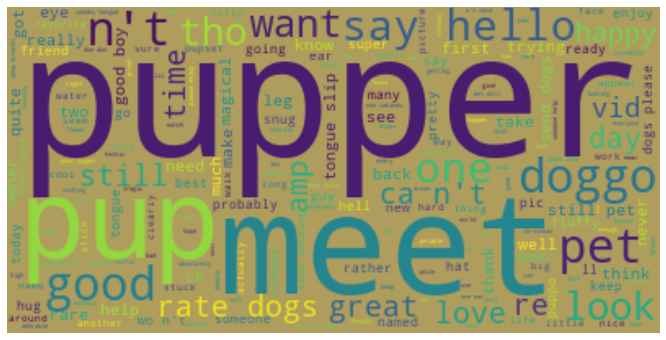

In [36]:
#import wordcloud
from wordcloud import WordCloud

#combine text column in one single text
text = ' '.join((n for n in list(twitt_arch.text.str.lower())))
text_tokenized = word_tokenize(text)
#remove stop words like the, he, she, etc...
text_no_stop_words = [x for x in text_tokenized if x not in stop_words.union({'would', 'af', 'dog', 'ckin', 'rt', 'dog_rates'})]
#create the actual wordcloud object, 
cloud = WordCloud(background_color='#AF9D5D').generate(' '.join(n for n in text_no_stop_words))


#plot the word cloud image for  A4 (portrait)
plt.figure(figsize = [11.69, 8.27])
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off');

#### 5.2 Page Popularity<a id='5.2'></a>

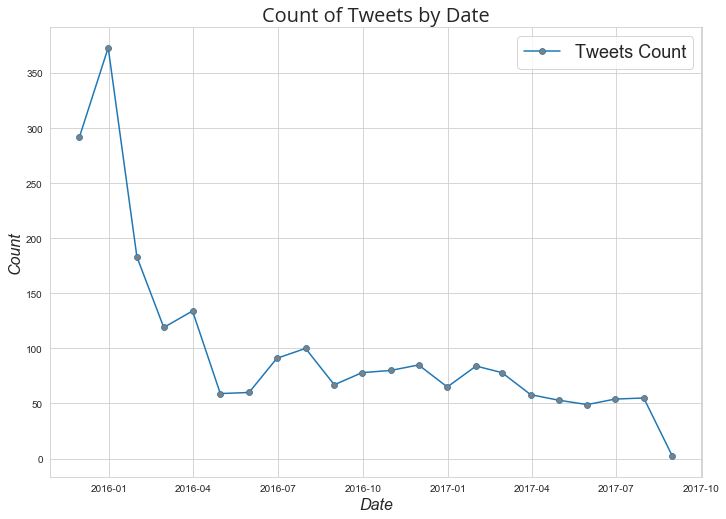

In [37]:
#set the timestamp to datetime object
twitt_arch.timestamp = pd.to_datetime(twitt_arch.timestamp)
data = twitt_arch
data.set_index('timestamp', inplace = True)
data = data.sort_index()
#resample the data by month and create the count of tweets in each month using the .size() method
data = data.resample('M').size()

#change the plotting syle
sns.set_style('whitegrid')
plt.figure(figsize = [11.69, 8.27])

#create a line plot of tweets count by date
ax = sns.lineplot(data=data, label = 'Tweets Count', marker = 'o', markerfacecolor = 'grey', markeredgecolor = None, hue = 'dog_stage')
ax.set_xlabel('Date', style='italic', size = 16)
ax.set_ylabel('Count', style='italic', size = 16)
ax.set_title('Count of Tweets by Date', style='italic', size = 20, fontname = 'Open Sans')
plt.legend(fontsize = 18);

#### 5.3 Rating and Dog Stage Heatmap<a id='5.3'></a>

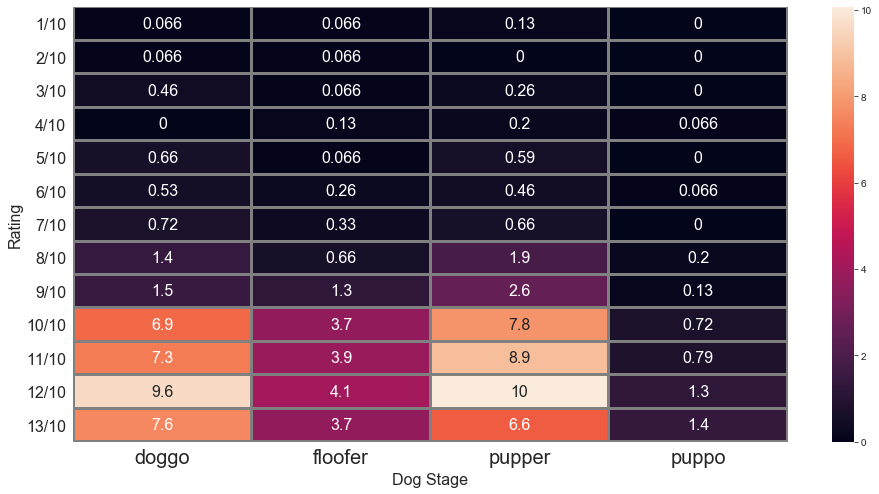

In [38]:
#create ordered category from the rating_numerator and rating_denominator columns
twitt_arch['rating'] = twitt_arch.rating_numerator.astype(str) + '/' + twitt_arch.rating_denominator.astype(str)
rating_order = ['1/10', '2/10', '3/10', '4/10', '5/10', '6/10', '7/10', '8/10', '9/10', '10/10', '11/10', '12/10', '13/10']
order = pd.api.types.CategoricalDtype(rating_order, ordered=True)
twitt_arch['rating'] = twitt_arch['rating'].astype(order)

#plot the count normalized heatmap of the dog_type vs the rating
plt.figure(figsize = (16, 8))
sns.heatmap((pd.crosstab(twitt_arch['rating'], twitt_arch['dog_stage'], normalize=True)*100), annot = True, linewidths = 2, linecolor='grey', annot_kws=dict(fontsize = 16))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 16, rotation = 0)
plt.xlabel('Dog Stage', fontsize = 16)
plt.ylabel('Rating', fontsize = 16);

#### 5.4 Proportion of Predictions that are Actual Dogs<a id='5.4'></a>

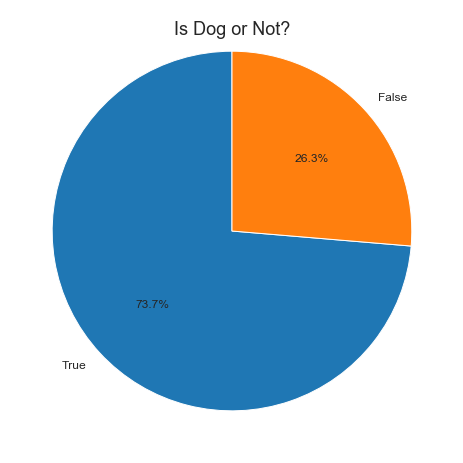

In [39]:
plt.figure(figsize = [11.69, 8.27])

#query data for the top prediction
data = img_pred.query('p_rank == 1').is_dog.value_counts()
#construct a pie plot
plt.pie(data, labels= data.index, autopct='%1.1f%%', startangle=90, textprops = dict(fontsize = 12))
plt.title('Is Dog or Not?', fontsize = 18, y = .925);

#### 5.5 Data Query<a id='5.5'></a>

   - Use SQL syntex to query a combined dataframe

In [40]:
#use pd.read_sql to query database
#filter only data that have p_rank equal to 1 (i.e most confident prediction), and the prediction is a dog
#filtering is in the WHERE statment in the sql syntex
combined = pd.read_sql("""SELECT text AS tweet_text, rating_numerator, rating_denominator, dog_stage, retweet_count, favorite_count, type AS media_type
                                FROM twitt_arch
                                JOIN img_pred
                                USING (tweet_id)
                                JOIN tweets
                                ON twitt_arch.tweet_id = tweets.id
                                WHERE p_rank = 1 AND is_dog = 1""", con = engine)

#Display the head of combined dataframe
combined.head()

,tweet_text,rating_numerator,rating_denominator,dog_stage,retweet_count,favorite_count,media_type
0,Here we have a Japanese Irish Setter. Lost eye...,8,10,None,462,2418,None
1,This is a western brown Mitsubishi terrier. Up...,7,10,None,42,121,photo
2,Here is a very happy pup. Big fan of well-main...,9,10,None,41,112,photo
3,This is a purebred Piers Morgan. Loves to Netf...,6,10,None,132,272,photo
4,Here we have a 1949 1st generation vulpix. Enj...,5,10,None,39,96,photo


#### 5.5.1 Analyze Tweet Sentiment<a id='5.5.1'></a>

   - Use `Sentiment Intesity Analyzer` from nltk package to `analyze the sentiment of each tweet`

In [41]:
#Import package
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
#Create the sentiment_score column where sentiment ranges from -1(most negaive review) to +1(most positive review) and 0 is neutral
combined['sentiment_score'] = combined.tweet_text.apply(sid.polarity_scores).apply(lambda x: x['compound'])

#### 5.5.2 Conclusion<a id='5.5.2'></a>

   - Visualize multiple variables with the rating

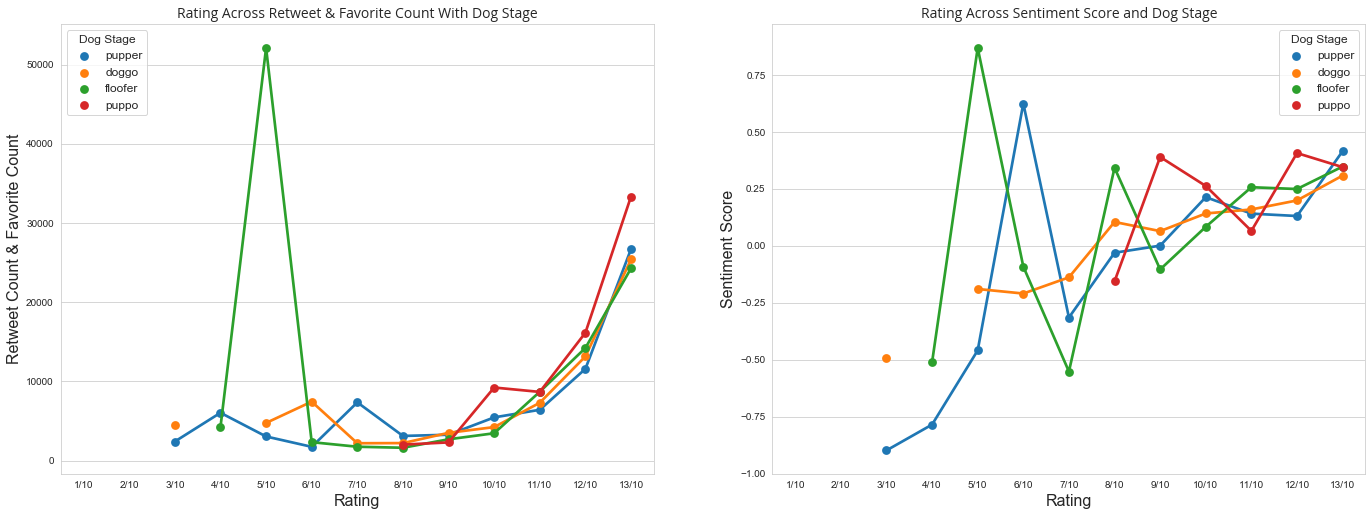

In [42]:
figure, ax = plt.subplots(1, 2, figsize=[11.69*2, 8.27])

#create a rating column
combined['rating'] = combined.rating_numerator.astype(str) + '/' + combined.rating_denominator.astype(str)
order = pd.api.types.CategoricalDtype(rating_order, ordered=True)
combined['rating'] = combined['rating'].astype(order)
#add the retweet_count with the favorite_count 
combined['retweet_favorite_count'] = combined.retweet_count.add(combined.favorite_count)

#Create point plot of Rating Across Retweet & Favorite Count With Dog Stage
ax[0] = sns.pointplot(data  = combined, x = 'rating', y = 'retweet_favorite_count', hue = 'dog_stage', errwidth=0, ax = ax[0])
ax[0].set_xlabel('Rating', fontsize = 16)
ax[0].set_ylabel('Retweet Count & Favorite Count', fontsize = 16)
ax[0].legend(title = 'Dog Stage', fontsize = 12, title_fontsize = 12)
ax[0].set_title('Rating Across Retweet & Favorite Count With Dog Stage', style='italic', size = 14, fontname = 'Open Sans')

#Create a point plot of Rating Across Sentiment Score and Dog Stage
ax[1] = sns.pointplot(data  = combined, x = 'rating', y = 'sentiment_score', hue = 'dog_stage', errwidth=0, ax = ax[1])
ax[1].set_xlabel('Rating', fontsize = 16)
ax[1].set_ylabel('Sentiment Score', fontsize = 16)
ax[1].legend(title = 'Dog Stage', fontsize = 12, title_fontsize = 12)
ax[1].set_title('Rating Across Sentiment Score and Dog Stage', style='italic', size = 14, fontname = 'Open Sans');